In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.externals import joblib


In [2]:
#MSSubClass is set of discrete ints, so this makes it easier to use it as a categorical feature
train_clean = pd.read_csv('train_clean.csv', dtype={'MSSubClass': str})  
train = pd.read_csv('train.csv', dtype={'MSSubClass': str})

In [5]:
kf = KFold( 4, shuffle=True)

In [8]:
val_idx_list = []
val_preds = []
train_preds = []
val_errors = []
train_rmse = []
val_rmse = []
X_train = train_clean.drop('SalePrice', axis=1)
y_train = train_clean['SalePrice']

for tr_idx, val_idx in kf.split(train):
    X_tr, y_tr = X_train.iloc[tr_idx, :], y_train.iloc[tr_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    val_idx_list.append(val_idx)
    ls = Lasso(alpha=0.001) #the hyperparameter we found to be best
    ls.fit(X_tr, y_tr)
    preds = ls.predict(X_val)
    val_preds.append(preds)
    val_errors.append(np.abs(y_val.values - preds))
    tr_preds = ls.predict(X_tr)
    train_preds.append(tr_preds)
    train_rmse.append(np.mean(np.sqrt((y_tr.values - tr_preds)**2)))
    val_rmse.append(np.mean(np.sqrt((y_val.values - preds)**2)))

print("mean val error: {}".format(np.mean(val_rmse)))
print("mean train error: {}".format(np.mean(train_rmse)))
    

mean val error: 0.08059387779020774
mean train error: 0.07438526483102641


In [9]:
val_idx = np.concatenate([l for l in val_idx_list])
val_preds = np.concatenate([p for p in val_preds])
val_errors = np.concatenate([e for e in val_errors])
merge_df = pd.DataFrame(np.hstack([val_preds[:, np.newaxis], val_errors[:, np.newaxis]]), columns=['log_pred', 'log_error'], index=val_idx)
err_df = train.merge(merge_df, left_index=True, right_index=True)

In [10]:
err_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_pred,log_error
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,MnPrv,Shed,700,10,2009,WD,Normal,143000,12.051035,0.180429
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,8,2007,WD,Normal,307000,12.536864,0.097742
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,NaN,Shed,350,11,2009,WD,Normal,200000,12.272555,0.066477
10,11,20,RL,70.0,11200,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,129500,11.759883,0.011561
12,13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,144000,11.809654,0.067922


In [11]:
err_df['pred'] = np.expm1(err_df.log_pred)
err_df['abs_error'] = np.abs(err_df.SalePrice - err_df.pred)
err_df['error'] = -(err_df.SalePrice - err_df.pred)

In [12]:
err_df.error.describe()

count      1460.000000
mean      -1023.196513
std       34689.206181
min     -300507.358300
25%      -10013.667478
50%        -551.541702
75%        8823.334016
max      848523.946635
Name: error, dtype: float64

Let's plot the errors versus saleprice and our predictions to get a better sense of where we went wrong.

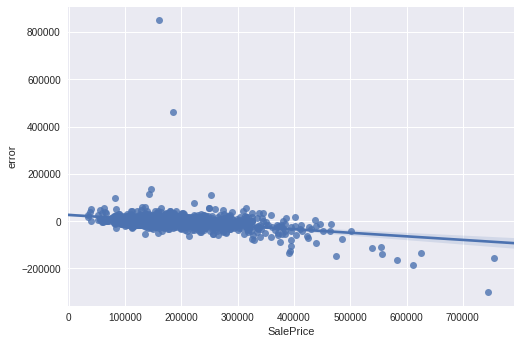

In [13]:
sns.regplot(x='SalePrice', y='error', data=err_df)

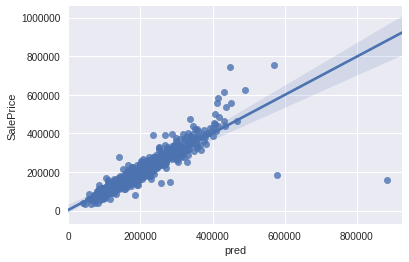

In [130]:
sns.regplot(y='SalePrice', x='pred', data=err_df)

It looks like we have four houses where we were way off. Let's take a look at them.

In [58]:
most_wrong = err_df.sort_values('abs_error', ascending=False)[:4]

In [59]:
most_wrong.index.values

array([1182,  898,  803, 1169])

In [28]:
most_wrong.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log_pred,log_error,pred,abs_error,error
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,1,2008,New,Partial,160000,13.823999,1.841064,1.008524e+06,848523.946635,848523.946635
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,10,2007,New,Partial,184750,13.380515,1.253751,6.472664e+05,462516.448796,462516.448796
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,7,2007,WD,Abnorml,745000,13.004691,0.516450,4.444926e+05,300507.358300,-300507.358300
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,3,2010,New,Partial,611657,12.964148,0.359781,4.268320e+05,184825.041332,-184825.041332


From a previous notebook, we learned that GrLivingArea, Neighborhood and OverallQual were the most important features. So let's hone in on those. 

In [30]:
train.GrLivArea.mean()

1515.463698630137

In [31]:
most_wrong.GrLivArea.mean()

4289.5

In [34]:
most_wrong.Neighborhood

1298    Edwards
523     Edwards
1182    NoRidge
898     NridgHt
Name: Neighborhood, dtype: object

In [32]:
train.OverallQual.mean()

6.0993150684931505

In [55]:
most_wrong.OverallQual.mean()

8.8

We can see that our potential outliers are large, high-quality houses. What's interesting is that we predicted too low a price for two of them, and too high a price for the other two. Two of the houses are partial sales and one was abnormal. Maybe that has something to do with it?

Neighborhood could also be the culprit. When we fit our original model, we found the Edwards neighborhood to be one of the strongest negative predictors of price. The two houses where we predicted too high a price were in Edwards. Maybe that's what dragged their price down?

Let's remove the outliers, fit a new model, and see what happens.

In [56]:
most_wrong.index.values

array([1182,  898,  803, 1169,  691,  690, 1046,  769,  527, 1142])

In [35]:
no_outliers = train_clean.drop(train_clean.index[most_wrong.index.values])

In [36]:
X = no_outliers.drop('SalePrice', axis=1)
y = no_outliers['SalePrice']

In [37]:
ls = Lasso(alpha=0.001)

In [40]:
ls.fit(X,y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
X_test = pd.read_csv('test_clean.csv')

In [42]:
preds = ls.predict(X_test)

In [43]:
preds = np.expm1(preds)

solution = pd.DataFrame({"id":X_test.Id, "SalePrice":preds}, columns=['id', 'SalePrice'])

solution.to_csv("lasso_no_outliers.csv", index = False)

That submission did score better that our previous submission. But I later discovered that removing only two of those four houses (the ones for which we predicted too high a price) worked even better. I think this is because many of our larger errors tended to be where we predicted too low a price. Removing the outliers where the price was unexpectedly low may have corrected some of this.

## Do it again

In [44]:
val_idx_list = []
val_preds = []
train_preds = []
val_errors = []
train_rmse = []
val_rmse = []

for tr_idx, val_idx in kf.split(X):
    X_tr, y_tr = X.iloc[tr_idx, :], y.iloc[tr_idx]
    X_val, y_val = X.iloc[val_idx, :], y.iloc[val_idx]
    val_idx_list.append(val_idx)
    ls = Lasso(alpha=0.001) #the hyperparameter we found to be best
    ls.fit(X_tr, y_tr)
    preds = ls.predict(X_val)
    val_preds.append(preds)
    val_errors.append(np.abs(y_val.values - preds))
    tr_preds = ls.predict(X_tr)
    train_preds.append(tr_preds)
    train_rmse.append(np.mean(np.sqrt((y_tr.values - tr_preds)**2)))
    val_rmse.append(np.mean(np.sqrt((y_val.values - preds)**2)))

print("mean val error: {}".format(np.mean(val_rmse)))
print("mean train error: {}".format(np.mean(train_rmse)))
    

mean val error: 0.07948534247008299
mean train error: 0.07205713453237914


In [45]:
val_idx = np.concatenate([l for l in val_idx_list])
val_preds = np.concatenate([p for p in val_preds])
val_errors = np.concatenate([e for e in val_errors])
merge_df = pd.DataFrame(np.hstack([val_preds[:, np.newaxis], val_errors[:, np.newaxis]]), columns=['log_pred', 'log_error'], index=val_idx)
err_df = train.merge(merge_df, left_index=True, right_index=True)

In [46]:
err_df['pred'] = np.expm1(err_df.log_pred)
err_df['abs_error'] = np.abs(err_df.SalePrice - err_df.pred)
err_df['error'] = -(err_df.SalePrice - err_df.pred)

In [ ]:
#remove outliers
#train = train[(train.Id != 1299) & (train.Id != 524)]


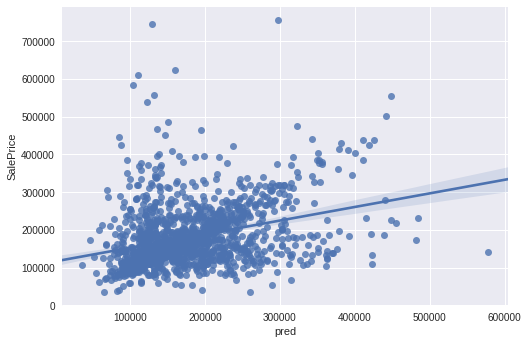

In [47]:
sns.regplot(y='SalePrice', x='pred', data=err_df)

In [49]:
most_wrong = err_df.sort_values('abs_error', ascending=False)[:10]

In [50]:
most_wrong.GrLivArea

1182    4476
898     2364
803     2822
1169    3627
691     4316
690      848
1046    2868
769     3279
527     2713
1142    2828
Name: GrLivArea, dtype: int64

In [51]:
most_wrong.OverallQual

1182    10
898      9
803      9
1169    10
691     10
690      6
1046     9
769      8
527      9
1142     8
Name: OverallQual, dtype: int64

In [52]:
most_wrong.Neighborhood

1182    NoRidge
898     NridgHt
803     NridgHt
1169    NoRidge
691     NoRidge
690     CollgCr
1046    StoneBr
769     StoneBr
527     NridgHt
1142    CollgCr
Name: Neighborhood, dtype: object

In [53]:
most_wrong.SaleCondition

1182    Abnorml
898     Partial
803     Partial
1169     Normal
691      Normal
690      Normal
1046    Partial
769      Normal
527     Partial
1142    Partial
Name: SaleCondition, dtype: object

In [54]:
train.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64